<a href="https://colab.research.google.com/github/rageoveralostpenny/3F8-Inference-Lab/blob/main/3F8_FTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First we download the data

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY' -O X.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15HONyJXWARLhNAtNQXFWAH8pvGPahh_U' -O y.txt

--2022-03-25 02:35:28--  https://docs.google.com/uc?export=download&id=1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY
Resolving docs.google.com (docs.google.com)... 172.217.13.78, 2607:f8b0:4004:c0b::66, 2607:f8b0:4004:c0b::71, ...
Connecting to docs.google.com (docs.google.com)|172.217.13.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-88-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4qn0cubnikl9psdaj1slfa3n5ceoghfn/1648175700000/03911252296720181638/*/1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY?e=download [following]
--2022-03-25 02:35:28--  https://doc-0c-88-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4qn0cubnikl9psdaj1slfa3n5ceoghfn/1648175700000/03911252296720181638/*/1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY?e=download
Resolving doc-0c-88-docs.googleusercontent.com (doc-0c-88-docs.googleusercontent.com)... 172.217.164.129, 2607:f8b0:4004:814::2001
Connecting to doc-0c-88-docs.googleusercontent.com (do

In [ ]:
# We load the data

import numpy as np
from scipy import stats
import scipy

X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')

# We randomly permute the data

permutation = np.random.permutation(X.shape[ 0 ])
X = X[ permutation, : ]
y = y[ permutation ]

In [ ]:
# We plot the data

import matplotlib.pyplot as plt

##
# Function that plots the points in 2D together with their labels
#
# Inputs:
#
# X: 2d array with the input features
# y: 1d array with the class labels (0 or 1)
#
# Output: 2D matrices with the x and y coordinates of the points shown in the plot
#

def plot_data_internal(X, y):
    # The 0.5 buffer on either side just acts to put some whitespace on the graph
    # x_min etc just sets the axes sizes
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.figure()
    plt.xlim(xx.min(None), xx.max(None))
    plt.ylim(yy.min(None), yy.max(None))
    ax = plt.gca()
    # Plot coefficients x1, x2 and visualise data on x1-x2 plane
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', markersize=2, label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', markersize=2, label = 'Class 2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Plot data')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
    return xx, yy

##
# Function that plots the data without returning anything by calling "plot_data_internal".
#
# Input:
#
# X: 2d array with the input features
# y: 1d array with the class labels (0 or 1)
#
# Output: Nothing.
#

def plot_data(X, y):
    xx, yy = plot_data_internal(X, y)
    plt.show()

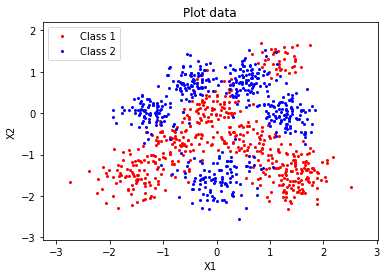

In [ ]:
plot_data(X, y)

In [ ]:
##
# Function that replaces initial input features by evaluating Gaussian basis functions
# on a grid of points
#
# Inputs:
#
# l: hyper-parameter for the width of the Gaussian basis functions
# Z: location of the Gaussian basis functions
# X: points at which to evaluate the basis functions
#
# Output: Feature matrix with the evaluations of the Gaussian basis functions.
#

def evaluate_basis_functions(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

In [ ]:
# The logistic function

def logistic(x): return 1.0 / (1.0 + np.exp(-x))

##
# Function that makes predictions with a logistic classifier
#
# Input:
#
# X_tilde: matrix of input features (with a constant 1 appended to the left) 
#         for which to make predictions
# w: vector of model parameters
#
# Output: The predictions of the logistic classifier as a vector of sigma function evaluations
#

def predict(X_tilde, w): return logistic(np.dot(X_tilde, w))

##
# Function that computes the average loglikelihood of the logistic classifier on some data.
#
# Input:
#
# X_tile: matrix of input features (with a constant 1 appended to the left) 
#         for which to make predictions
# y: vector of binary output labels 
# w: vector of model parameters
#
# Output: The average loglikelihood
#
# * below performs vector element-wise multiplication between vector y and vector np.log(output_prob)
# To get the total log-likelihood from the average, just multiply by N data points. Since we are trying to maximise this function, and 
# multiplication is a monotonic mapping, it suffices to maximise the average loglikelihood.

def compute_average_ll(X_tilde, y, w):
    output_prob = predict(X_tilde, w)
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))

##
# Function that expands a matrix of input features by adding a column equal to 1.
#
# Input:
#
# X: matrix of input features.
#  
# Output: Matrix x_tilde with one additional constant column equal to 1 added.
#

def get_x_tilde(X): 
  return np.concatenate( (np.ones((X.shape[0],1)) , X) ,  1)

In [ ]:
phi_length = X_tilde_train.shape[1]

def compute_posterior(w,X,y,var=1):
  output_prob = predict(X,w)
  ll = y * np.log(output_prob) + (1-y)*np.log(1.0-output_prob)
  return (np.dot(w,w)/(2*var) - np.sum(ll))

def compute_posterior_grad(w,X,y,var=1):
  sigmoid_value = predict(X,w)
  return w/var - np.matmul(np.transpose(X),(y-sigmoid_value))

def find_MAP(X,y,var=1):
  w_start = np.random.randn(phi_length)
  wmap,llmap,d = scipy.optimize.fmin_l_bfgs_b(compute_posterior, \
                                      w_start,compute_posterior_grad,(X,y,var))
  return wmap

def compute_hessian_inv(X,w,var=1):
  sigmoid_value = predict(X,w)
  # Use array broadcasting to row-wise multiply each row of X_tilde 
  # by the corresponding sigmoid function value
  c1 = np.multiply(sigmoid_value,(1-sigmoid_value))
  M1 = X*c1[:,None]
  H = np.identity(phi_length)/var + np.matmul(M1.transpose(),X)
  return np.linalg.inv(H)

def evidence_approx(X,y,w,hessian_inv,var=1):
  output_prob = predict(X,w)
  H = np.linalg.inv(hessian_inv)
  # More robust to numerical errors with small determinants
  sign,magnitude = np.linalg.slogdet(H)
  ll = y * np.log(output_prob) + (1-y) * np.log(1 - output_prob)
  lnZ = np.sum(ll) - np.dot(w,w)/(2*var) - phi_length*np.log(var)/2 \
  - sign*magnitude*0.5
  return lnZ

def laplace_predict(phi,var=1):
  var_a = np.matmul(phi.T,np.dot(hessian_inv,phi))
  mu_a = np.dot(phi,wmap)
  kappa = (1 + np.pi*var_a/8)**(-0.5)
  predictive = logistic(mu_a*kappa)
  return predictive

def get_laplace_predict_vector(X,y,var=1):
  return np.apply_along_axis(laplace_predict,1,X,var)

def compute_average_laplace_ll(X, y, w):
    output_prob = get_laplace_predict_vector(X,w)
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))

In [ ]:
# Thresholding on test dataset for confusion matrix - PART E
# PS ctrl + / to comment/uncomment

def compute_confusion(X_tilde,y,w):
  # We want to round the probability that the data has class 1, so just use the sigmoid output vector
  y_probabilities = predict(X_tilde,w)
  y_hat = np.round(y_probabilities)
  # Values in the predicted labels for which the actual labels are 0
  y_hat_0 = y_hat[y == 0]
  # Values in the predicted labels for which the actual labels are 1
  y_hat_1 = y_hat[y == 1]

  # Fraction of true negatives
  trueneg = (np.shape(y_hat_0)-np.sum(y_hat_0))/np.shape(y_hat_0)

  # Fraction of false positives
  falsepos = np.sum(y_hat_0)/np.shape(y_hat_0)

  # Fraction of false negatives
  falseneg = (np.shape(y_hat_1)-np.sum(y_hat_1))/np.shape(y_hat_1)

  # Fraction of true positives
  truepos = np.sum(y_hat_1)/np.shape(y_hat_1)
  print(trueneg,falsepos,falseneg,truepos)

In [ ]:
# Thresholding on test dataset for confusion matrix - PART E
# PS ctrl + / to comment/uncomment

def compute_confusion_laplace(X_tilde,y,var=1):
  # We want to round the probability that the data has class 1, so just use the sigmoid output vector
  y_probabilities = get_laplace_predict_vector(X_tilde,y,var)
  y_hat = np.round(y_probabilities)
  # Values in the predicted labels for which the actual labels are 0
  y_hat_0 = y_hat[y == 0]
  # Values in the predicted labels for which the actual labels are 1
  y_hat_1 = y_hat[y == 1]

  # Fraction of true negatives
  trueneg = (np.shape(y_hat_0)-np.sum(y_hat_0))/np.shape(y_hat_0)

  # Fraction of false positives
  falsepos = np.sum(y_hat_0)/np.shape(y_hat_0)

  # Fraction of false negatives
  falseneg = (np.shape(y_hat_1)-np.sum(y_hat_1))/np.shape(y_hat_1)

  # Fraction of true positives
  truepos = np.sum(y_hat_1)/np.shape(y_hat_1)
  print(trueneg,falsepos,falseneg,truepos)

In [ ]:
# We split the data into train and test sets
# This is random because the data has already been shuffled before plotting

n_train = 800
X_train = X[ 0 : n_train, : ]
X_test = X[ n_train :, : ]
y_train = y[ 0 : n_train ]
y_test = y[ n_train : ]

In [ ]:
l = 0.1

X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

wmap = find_MAP(X_tilde_train,y_train)
hessian_inv = compute_hessian_inv(X_tilde_train,wmap)
laplace_approx = scipy.stats.multivariate_normal(mean=wmap,cov=hessian_inv)

compute_confusion_laplace(X_tilde_train,y_train)
compute_confusion_laplace(X_tilde_test,y_test)
compute_confusion(X_tilde_test,y_test,wmap)

ll_MAP_train = compute_average_ll(X_tilde_train, y_train, wmap)
ll_MAP_test = compute_average_ll(X_tilde_test, y_test, wmap)

ll_laplace_train = compute_average_laplace_ll(X_tilde_train, y_train, wmap)
ll_laplace_test = compute_average_laplace_ll(X_tilde_test, y_test, wmap)

print(ll_MAP_train,ll_MAP_test)
print(ll_laplace_train,ll_laplace_test)

[0.94390244] [0.05609756] [0.05128205] [0.94871795]
[0.92708333] [0.07291667] [0.08653846] [0.91346154]
[0.92708333] [0.07291667] [0.08653846] [0.91346154]
-0.22155631336340897 -0.29541516967995995
-0.2608701417769734 -0.32277650409106956


In [ ]:
##
# Function that plots the Laplace approximated predictive probabilities of the logistic classifier
#
# Input:
#
# X: 2d array with the input features for the data (without adding a constant column with ones at the beginning)
# y: 1d array with the class labels (0 or 1) for the data
# w: parameter vector
# map_inputs: function that expands the original 2D inputs using basis functions.
#
# Output: Nothing.
#

def plot_laplace_predictive_distribution(X, y, map_inputs = lambda x : x):
    #xx and yy are a meshgrid of 100 points in each dimension between the maximum and minimum values of x, y
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = get_laplace_predict_vector(X_tilde, y)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 1)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

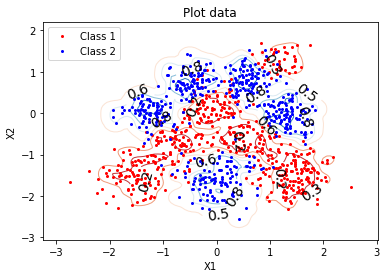

In [ ]:
# We plot the predictive distribution

plot_laplace_predictive_distribution(X, y, lambda x : evaluate_basis_functions(l, x, X_train))

In [ ]:
def plot_MAP_predictive_distribution(X, y, map_inputs = lambda x : x):
    #xx and yy are a meshgrid of 100 points in each dimension between the maximum and minimum values of x, y
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = predict(X_tilde,wmap)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 1)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

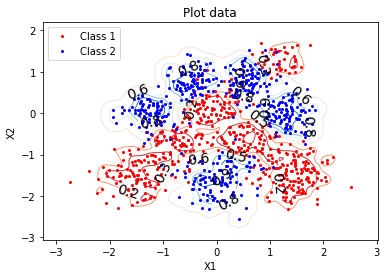

In [ ]:
plot_MAP_predictive_distribution(X, y, lambda x : evaluate_basis_functions(l, x, X_train))

In [ ]:
var_grid = np.logspace(np.log10(0.4),np.log10(1.5),10)
l_grid = np.logspace(np.log10(0.3),np.log10(0.8),10)

def expand_inputs(X,Z):
  return np.array([get_x_tilde(evaluate_basis_functions(l, X, Z)) for l in l_grid])

# X_tilde_train_3D, X_tilde_test_3D are 3D matrices of expanded inputs for all l values
# (10, 800, 801)
# Note 10 is the first dimension, for iteration later on
X_tilde_train_3D = expand_inputs(X_train,X_train)
X_tilde_test_3D = expand_inputs(X_test,X_train)

evidence_matrix = np.empty([10,10])

# Iterate over l values by iterating over slices of X_tilde_train_3D
for i in range(10):
  # Vectorize over var values in w prior
  # (10, 801) where 1st axis depends on variance of weight priors
  wmap_vector = np.array([find_MAP(X_tilde_train_3D[i,:,:],y_train,var) for var in var_grid])
  # (10, 801, 801) where 1st axis depends on variance of weight priors
  hessian_inv_vector = np.array([compute_hessian_inv(X_tilde_train_3D[i,:,:],w,var) \
                                 for w,var in zip(wmap_vector,var_grid)])
  evidence_vector = np.array([evidence_approx(X_tilde_train_3D[i,:,:],y_train,w,h,var) \
                           for w,h,var in zip(wmap_vector,hessian_inv_vector,var_grid)])
  evidence_matrix[i] = evidence_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


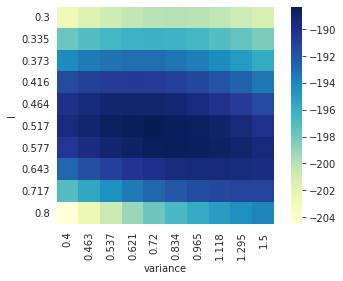

In [ ]:
import seaborn as sns

with sns.axes_style("white"):
    ax = sns.heatmap(evidence_matrix, square=True,  cmap="YlGnBu", xticklabels=np.round(var_grid,3), yticklabels=np.round(l_grid,3))
    plt.xlabel('variance', fontsize = 10) 
    plt.ylabel('l', fontsize = 10)
    plt.show()

In [ ]:
l = 0.52
var = 0.72

wmap = find_MAP(X_tilde_train,y_train,var)
hessian_inv = compute_hessian_inv(X_tilde_train,wmap,var)

X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

print('Confusion (me):')
compute_confusion_laplace(X_tilde_train,y_train,var)
compute_confusion_laplace(X_tilde_test,y_test,var)

ll_laplace_train = compute_average_laplace_ll(X_tilde_train, y_train, wmap)
ll_laplace_test = compute_average_laplace_ll(X_tilde_test, y_test, wmap)
print(ll_laplace_train,ll_laplace_test)

Confusion (me):
[0.92682927] [0.07317073] [0.08205128] [0.91794872]
[0.91666667] [0.08333333] [0.05769231] [0.94230769]
-0.19437047228129356 -0.23225927148984063


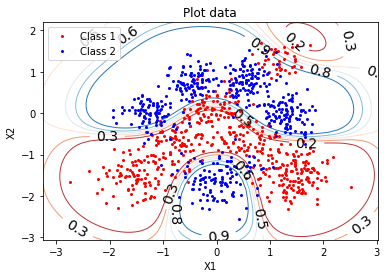

In [ ]:
plot_laplace_predictive_distribution(X, y, lambda x : evaluate_basis_functions(l, x, X_train))